# Collaborative Filtering

The following file summarizes the performed collaborative filtering methods.

In [1]:
# Import packages
import numpy as np
import pandas as pd
import time

from surprise import SVD, NMF, KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, NormalPredictor, BaselineOnly, CoClustering, SlopeOne
from surprise import Dataset, Reader, accuracy
from sklearn.model_selection import train_test_split
from surprise.model_selection import cross_validate, GridSearchCV, ShuffleSplit
from imblearn.under_sampling import RandomUnderSampler


# Load dataset
interactions = pd.read_csv('../data/RAW_interactions.csv', sep=',', parse_dates=['date'])
recipes = pd.read_csv('../data/RAW_recipes.csv', sep=',')
print('Unique rows in interactions: ', len(interactions))
print('Unique rows in recipes: ', len(recipes))

Using TensorFlow backend.


Unique rows in interactions:  1132367
Unique rows in recipes:  231637


In [3]:
%run functions.py

In [4]:
interactions.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


## Filter Strategies

In [4]:
# Extract only the relevant columns from the data set
ratings = interactions[['user_id', 'recipe_id', 'date', 'rating']].copy()

# Delete all '0' ratings
ratings = ratings[ratings.rating != 0]

evaluate_filtering(ratings, interactions)

# Apply first filtering on the data (ASSUMPTION: CF only reasonable if a few ratings exisit)
ratings = ratings.groupby("user_id").filter(lambda x: (len(x) > 10))
ratings = ratings.groupby("recipe_id").filter(lambda x: (len(x) > 10))

evaluate_filtering(ratings, interactions)

# Create a dictonary that stores all of our filtering possibilities
# filters = {"IQR": apply_filter(ratings, ["user_id", "recipe_id"], "iqr_filtering"),
#            "RandomSampling": apply_filter(ratings, ["user_id", "recipe_id"], "random_sampling", sample_size=5000),
#            "None": ratings
# }

filters = {"None" : ratings}

Number of ratings that are left: 1071520

Number of users that are left: 196098

Number of recipes that are left: 226590

Fraction of ratings that is left: 0.95

Fraction of users that is left: 0.87

Fraction of recipes that is left: 0.98

Number of ratings that are left: 313803

Number of users that are left: 11005

Number of recipes that are left: 11741

Fraction of ratings that is left: 0.28

Fraction of users that is left: 0.05

Fraction of recipes that is left: 0.05



## Algorithms

In [6]:
# Prep grid search

# Params
param_grid = {
    "KNNBasic" : {
        "k" : [20, 40, 60],
        "sim_options" : {
            "name" : ['cosine'],
            "user_based"  : [True, False],
        }
    },
    "KNNWithMeans" : {
        "k" : [40],
    },          
    "SVD" : {
        "n_factors" : [100]
    },
    "NMF" : {
        "n_factors" : [100]
    },
    "Baseline" : {}
}


# Algos
algos = {"SVD" : SVD, "NMF" : NMF, "KNNWithMeans": KNNWithMeans ,"Baseline" : NormalPredictor}
# algos = {"SVD" : SVD, "Baseline" : NormalPredictor}

## Pre Evaluation

In [14]:
# Test plot function
filtered_ratings = filters.get("RandomSampling")

# Create train-test split for model evaluation
ratings_train, ratings_test = train_test_split(filtered_ratings, test_size=0.3, random_state=42, shuffle=True, stratify=filtered_ratings.rating)

# Create dataset objects from the train-test-split which is required for suprise package 
trainset = Dataset.load_from_df(ratings_train, Reader())
testset = Dataset.load_from_df(ratings_test, Reader()).build_full_trainset().build_testset()

knnbasic_cv = cross_validate(KNNBasic(), trainset, cv=5, n_jobs=5, verbose=False)

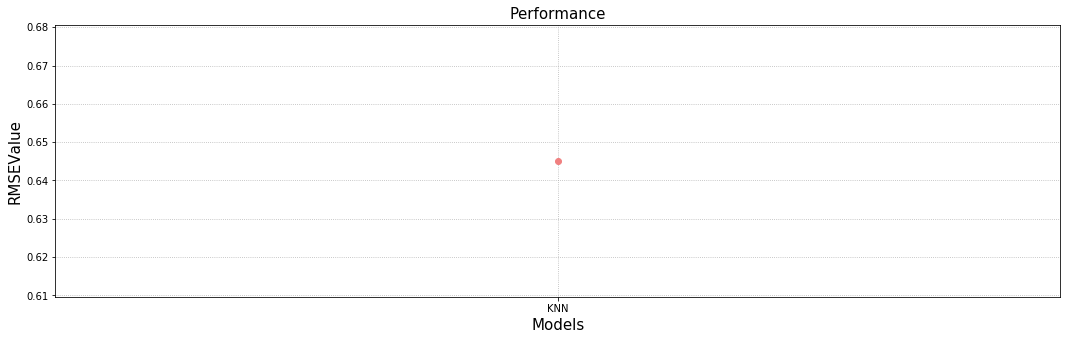

In [15]:
name = ["KNN"]

evaluation_plot([knnbasic_cv], name)

In [9]:
# Train-Test-Split

splits = ["LastRatingSplit"]

# Sampling
under_sampler = RandomUnderSampler()
# sampling_strategies = ["None", "RandomUnderSampling"]
sampling_strategies = ["None"]

# Benchmark
benchmark = []
fitted_algos = {}

# Cross-validation
cv = ShuffleSplit(n_splits = 2, test_size = 0.3, random_state=42, shuffle=True)

# Init output
pred_coverage =  0
cat_coverage = 0
nov = 0
pers = 0

### Evaluate the algorithms ###

# Evaluate per filter
for f_name, f in filters.items():
    
    # Apply the current filtering
    ratings = f
    
    # Print the key facts for the filtering
    evaluate_filtering(ratings, interactions)
    
    for split_name in splits:
        
        # Create train-test split for model evaluation
        if "StratifiedShuffledSplit":
            ratings_train, ratings_test = train_test_split(ratings, test_size=0.3, random_state=42, shuffle=True, stratify=ratings.rating)
        elif "LastRatingSplit":
            # Get the date of the last rating per user
            last_date_per_user = ratings.groupby("user_id").date.max().reset_index()
            # Select those dates per user and drop duplicates (multiple ratings are possible per day, we cannot distinguish which one was actually the last)
            ratings_test = ratings[pd.Index(ratings[["user_id", "date"]]).isin(pd.Index(last_date_per_user))].drop_duplicates(["user_id","date"])
            # Take the remaining ratings as train set
            ratings_train = ratings[~ratings.index.isin(ratings_test.index)]
        elif "LastYearsSplit":
            # Split based on last three year
            # Get the last three years
            last_years = ratings.date.dt.year.sort_values().unique()[-3:]
            # Build the test and train set on the last three years
            ratings_test = ratings[ratings.date.dt.year.isin(last_year)]
            ratings_train = ratings[~ratings.index.isin(ratings_test.index)]
        
        # Drop the 'date' column, as it is not required for suprise package
        ratings_test.pop('date')
        ratings_train.pop('date')
        
        for sampling_strategy in sampling_strategies:
            
            if sampling_strategy == "RandomUnderSampling":
                ratings_train, dummy = under_sampler.fit_resample(ratings_train, ratings_train.rating.astype("int"))
            
            # Evaluate each algorithm with tuned parameters
            for name, algo in algos.items():
                gs = GridSearchCV(algo, param_grid.get(name), measures=['rmse', 'mae'], cv=cv, refit=True, n_jobs=-1)

                # Refit the estimator with the best parameters on whole training set
                gs.fit(trainset)

                # Get the final rmse and mae scores on the test data
                predicitons = gs.test(testset)
                final_score_rmse = accuracy.rmse(predicitons)
                final_score_mae = accuracy.mae(predicitons)
                
                # Compute prediction coverage (Fraction of recipes that we are theoretically able to predict)
                pred_coverage = len(ratings_train.recipe_id.unique()) / len(interactions.recipe_id.unique())    
                
                prediction_sample = build_prediction_sample(ratings_train, 1000)
                
                # Estimate all ratings from the prediciton sample (contains only elements that are not in the train set)
                predicitionset = Dataset.load_from_df(prediction_sample, Reader()).build_full_trainset().build_testset()
                predictions = gs.test(predicitionset)
                
                # Get top n predicitions per user
                top_n = get_top_n(predictions, n=10)
                
                # Comput catalog coverage (Fraction of recipes that are predicted)
                cat_coverage = catalog_coverage(top_n, prediction_sample)
                
                # Compute novelty
                pop = Counter(ratings_train.recipe_id.values)
                n_unique_users = ratings_train.user_id.drop_duplicates().count()
                nov, mean_self_information = novelty(top_n, pop, n_unique_users, 10)
                
                # Compute personalization
                pers = personalization(top_n)
                
                # Store the fitted estimator for later use
                fitted_algos[name] = gs
                
                # Store the results
                benchmark.append([f_name, split_name, sampling_strategy,name, final_score_rmse, final_score_mae, pred_coverage, cat_coverage, pers, nov, gs.best_params])


# Display the results
results = pd.DataFrame(benchmark, columns=["Filter", "Split", "Balancing", "Algorithm", "FinalRMSE", 
                                           "FinalMAE", "PredictionCoverage", "CatalogCoverage", 
                                           "Personalization", "Novelty", "Params"])
results.set_index(["Filter", "Split", "Balancing", "Algorithm"], inplace=True)
results.sort_index(inplace=True)
results

Number of ratings that are left: 313803

Number of users that are left: 11005

Number of recipes that are left: 11741

Fraction of ratings that is left: 0.28

Fraction of users that is left: 0.05

Fraction of recipes that is left: 0.05

RMSE: 0.5640
MAE:  0.3562
RMSE: 0.6512
MAE:  0.2633
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.5919
MAE:  0.3614
RMSE: 0.7563
MAE:  0.5093


FinalRMSE  FinalMAE  \
Filter Split           Balancing Algorithm                           
None   LastRatingSplit None      Baseline       0.756281  0.509285   
                                 KNNWithMeans   0.591876  0.361372   
                                 NMF            0.651216  0.263318   
                                 SVD            0.564035  0.356191   

                                               PredictionCoverage  \
Filter Split           Balancing Algorithm                          
None   LastRatingSplit None      Baseline                0.050687   
                                 KNNWithMeans            0.050687   
                                 NMF                     0.050687   
                                 SVD                     0.050687   

                                               CatalogCoverage  \
Filter Split           Balancing Algorithm                       
None   LastRatingSplit None      Baseline                0.069   
                                 KNNWithMeans            0.777   
                                 NMF                     0.573   
                                 SVD                     0.725   

                                               Personalization   Novelty  \
Filter Split           Balancing Algorithm                                 
None   LastRatingSplit None      Baseline             0.716128  0.000820   
                                 KNNWithMeans         0.811734  0.000791   
                                 NMF                  0.112955  0.000800   
                                 SVD                  0.892604  0.000807   

                                                                                          Params  
Filter Split           Balancing Algorithm                                                        
None   LastRatingSplit None      Baseline                                {'rmse': {}, 'mae': {}}  
                                 KNNWithMeans              {'rmse': {'k': 40}, 'mae': {'k': 40}}  
                                 NMF           {'rmse': {'n_factors': 100}, 'mae': {'n_factor...  
                                 SVD           {'rmse': {'n_factors': 100}, 'mae': {'n_factor...

# Final Evaluation Approach (Part that needs to get merged)

### First performance evaluation for algos based on RMSE and MAE

In [9]:
# ASSUMPTION: Filtering is already carried out
# Compare Results of default algorihms on the problem to identify most promising once

algos = {
    'NormalPredictor': NormalPredictor, 
    'BaselineOnly': BaselineOnly, 
    'KNNBasic': KNNBasic, 
    'KNNWithMeans': KNNWithMeans,
    'KNNWithZScore': KNNWithZScore,
    'KNNBaseline': KNNBaseline,
    'SVD': SVD,
    'SVDpp': SVDpp,
    'SlopeOne': SlopeOne,
    'CoClustering': CoClustering
}

# Build train-test-split
# Get the date of the last rating per user
last_date_per_user = ratings.groupby("user_id").date.max().reset_index()
# Select those dates per user and drop duplicates (multiple ratings are possible per day, we cannot distinguish which one was actually the last)
ratings_test = ratings[pd.Index(ratings[["user_id", "date"]]).isin(pd.Index(last_date_per_user))].drop_duplicates(["user_id","date"])
# Take the remaining ratings as train set
ratings_train = ratings[~ratings.index.isin(ratings_test.index)]

# Build cross validation split
cv = ShuffleSplit(n_splits = 5, test_size = 0.3, random_state=42, shuffle=True)

# Create dataset objects from the train-test-split which is required for suprise package 
trainset = Dataset.load_from_df(ratings_train[['user_id','recipe_id', 'rating']], Reader())
# Results dict
results_algos = {}

# Evaluate each algorithm with default settings
for name, algo in algos.items():
    cs = cross_validate(algo(), trainset, cv=cv, n_jobs=-1)
    results_algos.update({name: [np.mean(cs.get('test_rmse')), np.mean(cs.get('test_mae'))]})

results_algos_df = pd.DataFrame.from_dict(results_algos, orient='index', columns=['DevRMSE', 'DevMAE'])
results_algos_df

,DevRMSE,DevMAE
NormalPredictor,0.754161,0.509850
BaselineOnly,0.554558,0.356259
KNNBasic,0.619738,0.380441
KNNWithMeans,0.582564,0.357762
KNNWithZScore,0.594504,0.353830
KNNBaseline,0.580115,0.360106
SVD,0.560062,0.353890
SVDpp,0.557210,0.349371
SlopeOne,0.598859,0.370804
CoClustering,0.594090,0.356796


### Proceed with two most promising algos (should we keep that?)

In [70]:
# Investigate whether there are time dependent effects
algos = { 
    'BaselineOnly': BaselineOnly, 
    'SVD': SVD,
}

splits = ["LastRatingSplit", "LastYearsSplit", "StratifiedShuffledSplit"]

results_time = []


for split_name in splits:
    # Create train-test split for model evaluation
    if "StratifiedShuffledSplit":
        ratings_train, ratings_dev = train_test_split(ratings_train, test_size=0.3, random_state=42, shuffle=True, stratify=ratings_train.rating)
    elif "LastRatingSplit":
        # Get the date of the last rating per user
        last_date_per_user = ratings_train.groupby("user_id").date.max().reset_index()
        # Select those dates per user and drop duplicates (multiple ratings are possible per day, we cannot distinguish which one was actually the last)
        ratings_dev = ratings_train[pd.Index(ratings_train[["user_id", "date"]]).isin(pd.Index(last_date_per_user))].drop_duplicates(["user_id","date"])
        # Take the remaining ratings as train set
        ratings_train = ratings_train[~ratings_train.index.isin(ratings_dev.index)]
    elif "LastYearsSplit":
        # Split based on last three year
        # Get the last three years
        last_years = ratings_train.date.dt.year.sort_values().unique()[-3:]
        # Build the test and train set on the last three years
        ratings_dev = ratings_train[ratings_train.date.dt.year.isin(last_year)]
        ratings_train = ratings_train[~ratings_train.index.isin(ratings_dev.index)]

    # Create dataset objects from the train-test-split which is required for suprise package 
    trainset = Dataset.load_from_df(ratings_train[['user_id','recipe_id', 'rating']], Reader()).build_full_trainset()
    devset = Dataset.load_from_df(ratings_dev[['user_id','recipe_id', 'rating']], Reader()).build_full_trainset().build_testset()

    # Evaluate each algorithm with default settings
    for name, algo in algos.items():
        predictions = algo().fit(trainset).test(devset)
        results_time.append([name, split_name, accuracy.rmse(predictions), accuracy.mae(predictions)])
        
results_time_df = pd.DataFrame(results_time, columns=['Algorithm', 'Split', 'DevRMSE', 'DevMAE']).set_index(['Algorithm', 'Split']).sort_index()
results_time_df

Estimating biases using als...
RMSE: 0.5564
MAE:  0.3653
RMSE: 0.5611
MAE:  0.3597
RMSE: 0.5575
MAE:  0.3540
Estimating biases using als...
RMSE: 0.5637
MAE:  0.3725
RMSE: 0.5692
MAE:  0.3671
RMSE: 0.5635
MAE:  0.3589
Estimating biases using als...
RMSE: 0.5669
MAE:  0.3763
RMSE: 0.5706
MAE:  0.3687
RMSE: 0.5671
MAE:  0.3616


DevRMSE    DevMAE
Algorithm    Split                                      
BaselineOnly LastRatingSplit          0.556420  0.365298
             LastYearsSplit           0.563677  0.372489
             StratifiedShuffledSplit  0.566919  0.376323
SVD          LastRatingSplit          0.561138  0.359702
             LastYearsSplit           0.569203  0.367071
             StratifiedShuffledSplit  0.570613  0.368715
SVDpp        LastRatingSplit          0.557494  0.354024
             LastYearsSplit           0.563468  0.358878
             StratifiedShuffledSplit  0.567055  0.361554

### Hyperparamter Tuning / Model Selection

In [ ]:
# Evaluate each algorithm with tuned parameters
algos = { 
    'BaselineOnly': BaselineOnly,
    "KNNBaseline": KNNBaseline,
    'SVD': SVD,
}

# Store the fitted algorithms for later use
fitted_algos = {}

# List to store the final results for the estimators in
benchmark = []

# Rebuild train-test-split as it was changed to check for time dependent effects
# Get the date of the last rating per user
last_date_per_user = ratings.groupby("user_id").date.max().reset_index()
# Select those dates per user and drop duplicates (multiple ratings are possible per day, we cannot distinguish which one was actually the last)
ratings_test = ratings[pd.Index(ratings[["user_id", "date"]]).isin(pd.Index(last_date_per_user))].drop_duplicates(["user_id","date"])
# Take the remaining ratings as train set
ratings_train = ratings[~ratings.index.isin(ratings_test.index)]

# Create dataset objects from the train-test-split which is required for suprise package 
trainset = Dataset.load_from_df(ratings_train[['user_id','recipe_id', 'rating']], Reader())
testset = Dataset.load_from_df(ratings_test[['user_id','recipe_id', 'rating']], Reader()).build_full_trainset().build_testset()
# Use a predicition set for calcualting measures of diversity and get TOP-K-Lists (contains only elements that are not rated yet)
predictionset = Dataset.load_from_df(ratings[['user_id','recipe_id', 'rating']], Reader()).build_full_trainset().build_testset()

# Define the parameter grid
param_grid = {
    "KNNBaseline" : {
        "k" : [20, 40, 80],
        "sim_options" : {
            "name" : ['cosine', 'msd', 'pearson']
        },
        "min_support": [0,1,2,4]
    },     
    "SVD" : {
        "n_factors" : [10, 100, 1000],
        "lr_all": [0.0025, 0.005, 0.01],
        "reg_all": [0.01, 0.02, 0.04]
    },
    "BaselineOnly" : {}
}

for name, algo in algos.items():
    print(name)
    gs = GridSearchCV(algo, param_grid.get(name), measures=['rmse', 'mae'], cv=cv, refit=True, n_jobs=-1)

    start_gs = time.time()
    # Fit the estimator
    gs.fit(trainset)
    end_gs = time.time()
    print(f'GridSearch: {round(end_gs-start_gs, 2)}s')
    
    start_final_scores = time.time()
    # Get the final rmse and mae scores on the test data
    predictions = gs.test(testset)
    final_score_rmse = accuracy.rmse(predictions)
    final_score_mae = accuracy.mae(predictions)
    end_final_scores = time.time()
    print(f'TestScores: {round(end_final_scores-start_final_scores, 2)}s')

    # Compute prediction coverage (Fraction of recipes that we are theoretically able to predict)
    start_pred_coverage = time.time()
    pred_coverage = len(ratings_train.recipe_id.unique()) / len(interactions.recipe_id.unique())    
    end_pred_coverage = time.time()
    print(f'Predicition Coverage: {round(end_pred_coverage-start_pred_coverage, 2)}s')
    
    # Get predicitions for all entries in the train set
    start_pred = time.time()    
    predictions = gs.test(predictionset)
    end_pred = time.time()
    print(f'Estimate ratings: {round(end_pred-start_pred, 2)}s')
    
    # Get top n predicitions per user
    start_topk = time.time()
    top_n = get_top_n(predictions, n=10)
    end_topk = time.time()
    print(f'Top K: {round(end_topk-start_topk, 2)}s')

    # Comput catalog coverage (Fraction of recipes that are predicted)
    start_catalog_coverage = time.time()
    cat_coverage = catalog_coverage(top_n, ratings_train)
    end_catalog_coverage = time.time()
    print(f'Catalog Coverage: {round(end_catalog_coverage-start_catalog_coverage, 2)}s')
    
    # Compute novelty
    start_nov = time.time()
    pop = Counter(ratings_train.recipe_id.values)
    n_unique_users = ratings_train.user_id.drop_duplicates().count()
    nov, mean_self_information = novelty(top_n, pop, n_unique_users, 10)
    end_nov = time.time()
    print(f'Novelty: {round(end_nov-start_nov, 2)}s')

    # Compute personalization
    start_personalization = time.time()
    pers = personalization(top_n)
    end_personalization = time.time()
    print(f'Personalization: {round(end_personalization-start_personalization, 2)}s')


    # Store the fitted estimator for later use
    fitted_algos[name] = gs

    # Store the results
    benchmark.append([name, final_score_rmse, final_score_mae, pred_coverage, cat_coverage, pers, nov, gs.best_params])


# Display the results
results = pd.DataFrame(benchmark, columns=["Algorithm", "TestRMSE", 
                                           "TestMAE", "PredictionCoverage", "CatalogCoverage", 
                                           "Personalization", "Novelty", "Params"])
results.set_index(["Algorithm"], inplace=True)
results.sort_index(inplace=True)
results